In [9]:
import json
from pathlib import Path

In [10]:
# Importing the dataset.
# The LIDAR server produces samples at 30Hz with object positions normalized in their
# space, i.e. x and y values are in the 0-1 range.
datadir = Path("../testdata")
names = [
    "dump-1731964073793.jsonl",
    "dump-1731965089198.jsonl",
    "dump-1731966752296.jsonl"
]

data = []
for name in names:
    path = datadir.joinpath(datadir, name)
    f = open(path, 'r')
    last_is_zero = False
    for line in f.readlines():
        d = json.loads(line)
        if d['type'] != 'object':
            continue
        payload = d['payload']
        # At the beginning and end of the session there is nobody on stage and
        # there are many 0,0 points.
        is_zero = payload['x'] == 0 and payload['y'] == 0
        if is_zero:
            continue
            
        data.append({
            'x': payload['x'],
            'y': payload['y'],
        })

In [3]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

class PointSequenceDataset(Dataset):
    def __init__(self, data, sequence_length=10):
        self.sequence_length = sequence_length
        
        # Convert data to numpy array
        xy_points = np.array([[d['x'], d['y']] for d in data])
        
        # Create sequences
        self.sequences = []
        self.targets = []
        
        for i in range(len(xy_points) - sequence_length):
            self.sequences.append(xy_points[i:i + sequence_length])
            self.targets.append(xy_points[i + sequence_length])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.FloatTensor(self.targets[idx])

class PointPredictor(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, num_layers=2):
        super(PointPredictor, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Linear layer without activation to allow values in 0-1 range
        self.linear = nn.Linear(hidden_size, 2)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])
        
        # Clamp to ensure values stay in 0-1 range
        predictions = torch.clamp(predictions, 0, 1)
        return predictions

def train_model(data, epochs=200, sequence_length=10, batch_size=32):
    # Create dataset and dataloader
    dataset = PointSequenceDataset(data, sequence_length=sequence_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model, loss function, and optimizer
    model = PointPredictor()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for sequences, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.6f}')
    
    return model

def predict_next_point(model, sequence):
    model.eval()
    with torch.no_grad():
        # Convert input sequence to tensor
        sequence_tensor = torch.FloatTensor(
            np.array([[point['x'], point['y']] for point in sequence])
        ).unsqueeze(0)  # Add batch dimension
        
        # Predict point
        prediction = model(sequence_tensor)
        
        return {
            'x': prediction[0][0].item(), 
            'y': prediction[0][1].item()
        }

In [ ]:
model = train_model(data)

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class PointGenerator:
    def __init__(self, model, initial_sequence):
        """
        Initialize point generator with trained model and initial sequence
        
        :param model: Trained LSTM model
        :param initial_sequence: Initial sequence of points to start generation
        """
        self.model = model
        self.current_sequence = initial_sequence
        
    def generate_points(self, num_points):
        """
        Generate a sequence of points using the trained model
        
        :param num_points: Number of points to generate
        :return: List of generated points
        """
        generated_points = []
        current_seq = self.current_sequence.copy()
        
        for _ in range(num_points):
            # Prepare sequence tensor
            sequence_tensor = torch.FloatTensor(
                np.array([[point['x'], point['y']] for point in current_seq])
            ).unsqueeze(0)
            
            # Predict next point
            with torch.no_grad():
                prediction = self.model(sequence_tensor)
            
            # Convert prediction to point
            new_point = {
                'x': prediction[0][0].item(), 
                'y': prediction[0][1].item()
            }
            
            generated_points.append(new_point)
            
            # Update sequence by removing oldest point and adding new point
            current_seq = current_seq[1:] + [new_point]
        
        return generated_points

def plot_points_with_time_gradient(points):
    """
    Create a scatter plot of points with color gradient representing time
    
    :param points: List of generated points
    """
    # Extract x and y coordinates
    x_coords = [point['x'] for point in points]
    y_coords = [point['y'] for point in points]
    
    # Create color gradient based on point index (time)
    colors = plt.cm.viridis(np.linspace(0, 1, len(points)))
    
    # Create scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(x_coords, y_coords, c=range(len(points)), 
                          cmap='viridis', s=10, alpha=0.7)
    
    plt.colorbar(scatter, label='Time Progression')
    plt.title('Generated Points with Time Gradient')
    plt.xlabel('X')
    plt.ylabel('Y')
    
    # Add a few annotations to show progression
    sample_indices = [0, len(points)//4, len(points)//2, 
                      3*len(points)//4, len(points)-1]
    for idx in sample_indices:
        plt.annotate(f'Step {idx}', 
                     (x_coords[idx], y_coords[idx]), 
                     xytext=(10, 10), 
                     textcoords='offset points',
                     color=colors[idx],
                     fontweight='bold')
    
    plt.tight_layout()
    plt.show()


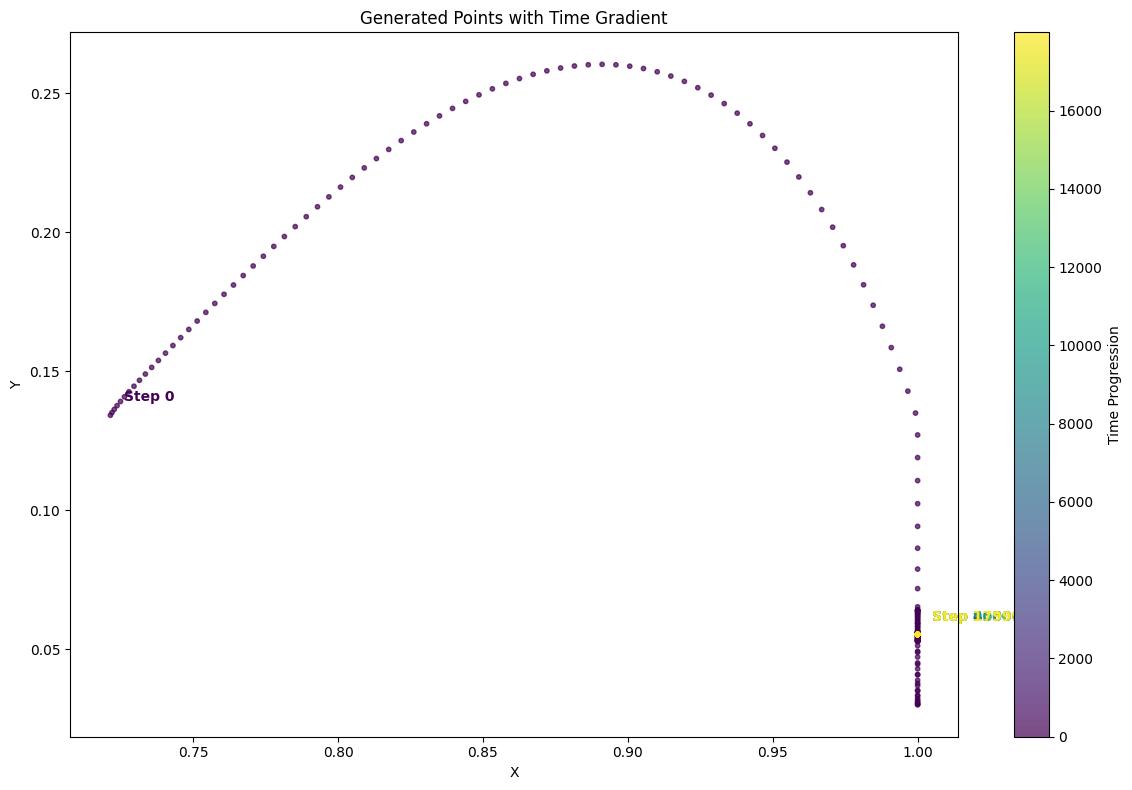

In [23]:
# Let's generate a huge session starting from the last point of the dataset.
initial_sequence = data[100:110]

# Initialize point generator
point_generator = PointGenerator(trained_model, initial_sequence)
    
# Generate points
generated_points = point_generator.generate_points(18000)
    
# Plot generated points
plot_points_with_time_gradient(generated_points)